# Introduction to Neural Force Field

This Jupyter Notebook contains an introduction to the `nff` package. Here, we will load the modules and functions from `nff` to import a dataset, create dataloaders, create a model, train it and check the test stats. We will do most of it manually to illustrate the usage of the API. However, scripts such as the one provided in the `scripts/` folder already automate most of this process.

After the `nff` package has been installed, we start by importing all dependencies for this tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam

from nff.data import Dataset, GraphLoader, split_train_validation_test
from nff.train import Trainer, get_trainer, get_model, loss, hooks, metrics, evaluate

## Loading the relevant data

As we usually work with the database, we can pack their information in a class `Dataset`, which is a subclass of `torch.utils.data.Dataset`. It basically wraps information on the atomic numbers, energies, forces and SMILES strings for each one of the geometries. In this example, we already have a pre-compiled `Dataset` to be used. We start by loading this file and creating three slices of the original dataset

In [2]:
dataset = Dataset.from_file('dataset.pth.tar')
train, val, test = split_train_validation_test(dataset, val_size=0.2, test_size=0.2)

The `nff` code interfaces with the `graphbuilder` module through a git submodule in the repository. `graphbuilder` provides methods to create batches of graphs. In `nff`, we interface that through a custom dataloader called `
GraphLoader`. Here, we create one loader for each one of the slices.

In [3]:
train_loader = GraphLoader(train, batch_size=50, cutoff=5, device=0)
val_loader = GraphLoader(val, batch_size=50, cutoff=5, device=0)
test_loader = GraphLoader(test, batch_size=50, cutoff=5, device=0)

Finished Batching 13 Batches
Finished Batching 4 Batches
Finished Batching 4 Batches


## Creating a model

`nff` is based on SchNet. It parameterizes interatomic interactions in molecules and materials through a series of convolution layers with continuous filters. Here, we are going to create a simple model using the hyperparameters given on `params`:

In [4]:
params = {
    'n_atom_basis': 256,
    'n_filters': 256,
    'n_gaussians': 32,
    'n_convolutions': 10,
    'cutoff': 5.0,
    'trainable_gauss': True
}

model = get_model(params)

## Creating a trainer

To train our model with the data provided, we have to create a loss function. The easiest way to do that is through the `build_mse_loss` builder. Its argument `rho` is a parameter that will multiply the mean square error (MSE) of the force components before summing it with the MSE of the energy.

In [5]:
loss_fn = loss.build_mse_loss(rho=1)

We should also select an optimizer for our recently created model:

In [6]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

### Metrics and hooks

Metrics and hooks allow the customization of the training process. Instead of tweaking directly the code or having to resort to countless flags, we can create submodules (or add-ons) to monitor the progress of the training or customize it.

If we want to monitor the progress of our training, say by looking at the mean absolute error (MAE) of energies and forces, we can simply create metrics to observe them:

In [7]:
train_metrics = [
    metrics.MeanAbsoluteError('energy'),
    metrics.MeanAbsoluteError('force')
]

Furthermore, if we want to customize how our training procedure is done, we can use hooks which can interrupt or change the train automatically.

In our case, we are adding hooks to:
* Stop the training procedure after 100 epochs;
* Log the training on a machine-readable CSV file under the directory `./sandbox`;
* Print the progress on the screen with custom formatting; and
* Setup a scheduler for the learning rate.

In [8]:
train_hooks = [
    hooks.MaxEpochHook(100),
    hooks.CSVHook(
        './sandbox',
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        './sandbox',
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

### Trainer wrapper

A `Trainer` in the `nff` package is a wrapper to train a model. It automatically creates checkpoints, as well as trains and validates a given model. It also allow further training by loading checkpoints from existing paths, making the training procedure more flexible. Its functionalities can be extended by the hooks we created above. To create a trainer, we have to execute the following command:

In [9]:
T = Trainer(
    model_path='./sandbox',
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
    hooks=train_hooks
)

Now we can finally train the model using the method `train` from the `Trainer`:

In [10]:
T.train(device=0, n_epochs=50)

               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy | MAE_force


## Evaluating the model on the test set

Now we have a brand new model trained and validated. We can use the best model from this training to evaluate its performance on the test set. `results` contains the predictions of properties for the whole test dataset. `targets` contains the ground truth for such data. `test_loss` is the loss, calculated with the same function used during the training part

In [11]:
results, targets, val_loss = evaluate(T.get_best_model(), test_loader, loss_fn, device=0)

Finally, we can plot our results to observe how well is our model performing:

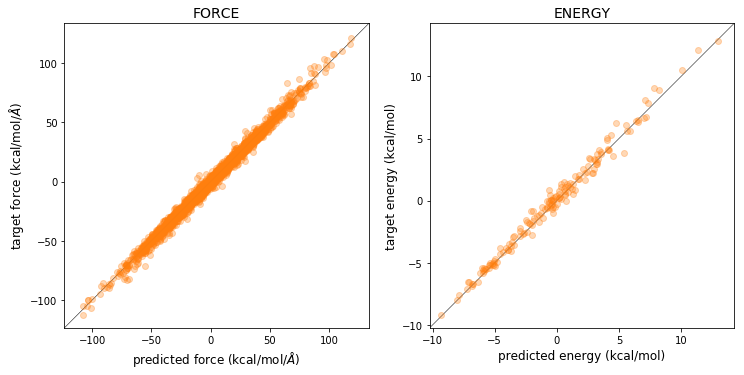

In [14]:
units = {
    'force': r'kcal/mol/$\AA$',
    'energy': 'kcal/mol'
}

fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

for ax, key in zip(ax_fig, results.keys()):
    pred = results[key].reshape(-1).data.cpu().numpy()
    targ = targets[key].reshape(-1).data.cpu().numpy()
    
    ax.scatter(pred, targ, color='#ff7f0e', alpha=0.3)
    
    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1
    
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect('equal')
    
    ax.plot((lim_min, lim_max),
            (lim_min, lim_max),
            color='#000000',
            zorder=-1,
            linewidth=0.5)
    
    ax.set_title(key.upper(), fontsize=14)
    ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
    ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)

plt.show()

The model is performing quite well.